# **Percobaan 6**

learning_rate = 0.00001
epoch = 10
batch size = 64

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
import cv2
import zipfile
import datetime
import glob as gb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.applications.vgg16 import VGG16

from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import auc, roc_curve

from google.colab import files, drive

# **Mendefinisikan Parameter**

In [ ]:
epoch = 10
batch_size = 64
learning_rate = 0.00001
img_size = 150

# **Download Dataset dari Kaggle**

In [ ]:
kaggle = files.upload()

with open("kaggle.json", "wb") as f:
  f.write(kaggle['kaggle.json'])

Saving kaggle.json to kaggle.json


In [ ]:
!KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [01:43<00:00, 23.8MB/s]
100% 2.29G/2.29G [01:43<00:00, 23.7MB/s]


In [ ]:
zip_file = zipfile.ZipFile('/content/chest-xray-pneumonia.zip')
zip_file.extractall('/content/')

# **Melihat Gambar Dataset**

In [ ]:
code = {'NORMAL':0 ,'PNEUMONIA':1}

def getcode(n) :
    for x , y in code.items() :
        if n == y :
            return x

classes = ['Normal', 'Pneumonia']

In [ ]:
def read_images_from_path(path, img_dim, grey_scale=0):
  X = []
  y = []
  for folder in  os.listdir(path) :
    files = gb.glob(pathname= str(path + folder + '/*.jpeg'))
    for file in files:
        #membaca gambar dengan grey scale
        if grey_scale == 1:
          image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        else:
          image = cv2.imread(file)
        image_array = cv2.resize(image , (img_dim, img_dim))
        X.append(list(image_array))
        y.append(code[folder])
  return np.array(X), np.array(y)

X_train, y_train = read_images_from_path('/content/chest_xray/train/', img_size, 1)
X_val, y_val = read_images_from_path('/content/chest_xray/val/', img_size, 1)
X_test, y_test = read_images_from_path('/content/chest_xray/test/', img_size, 1)

In [ ]:
print('X_train Shape: ' + str(X_train.shape))
print('X_test Shape: ' + str(X_test.shape))
print('X_val Shape: ' + str(X_val.shape))

X_train Shape: (5216, 150, 150)
X_test Shape: (624, 150, 150)
X_val Shape: (16, 150, 150)


# **Analisa dan Visualisasi Data**

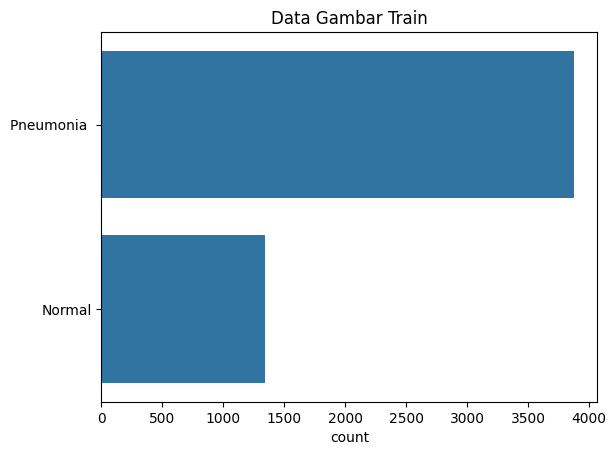

In [ ]:
count = []
for i in y_train:
    if(i == 0):
        count.append("Normal")
    else:
        count.append("Pneumonia ")
sns.countplot(count)
plt.title('Data Gambar Train')
plt.show()

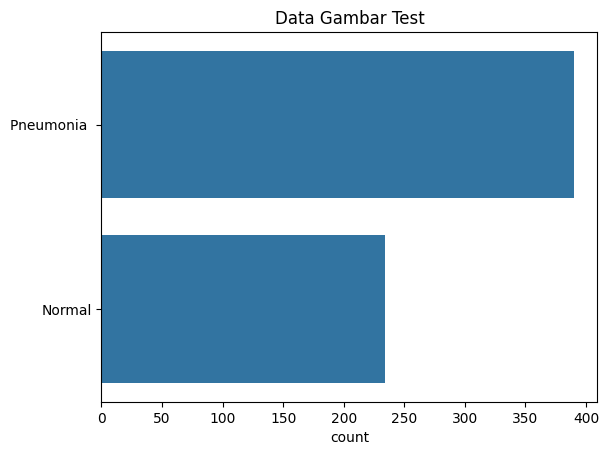

In [ ]:
count = []
for i in y_test:
    if(i == 0):
        count.append("Normal")
    else:
        count.append("Pneumonia ")
sns.countplot(count)
plt.title('Data Gambar Test')
plt.show()

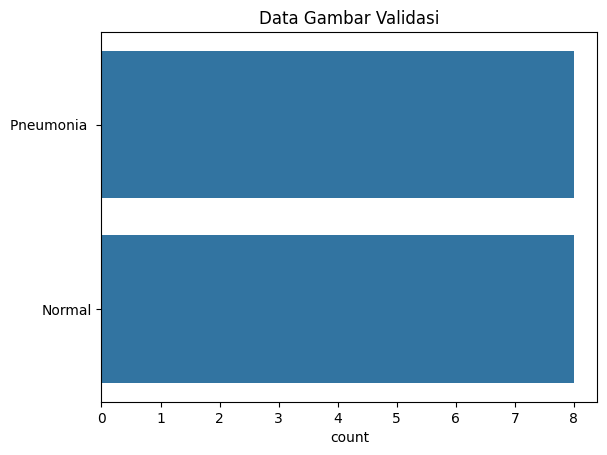

In [ ]:
count = []
for i in y_val:
    if(i == 0):
        count.append("Normal")
    else:
        count.append("Pneumonia ")
sns.countplot(count)
plt.title('Data Gambar Validasi')
plt.show()

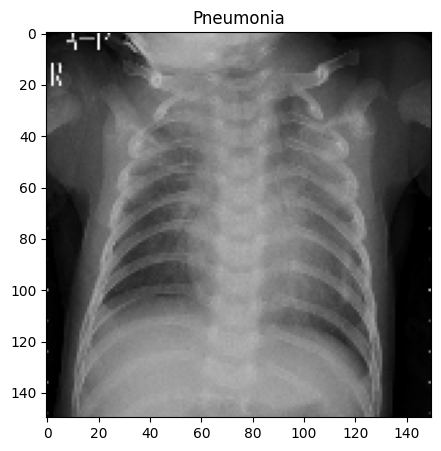

In [ ]:
# Melihat gambar secara random
img_no = np.random.randint(0, X_train.shape[1])
plt.figure(figsize = (5,5))
plt.imshow(X_train[img_no], cmap='gray')
plt.title(classes[y_train[img_no]])
plt.grid(False)
plt.show()

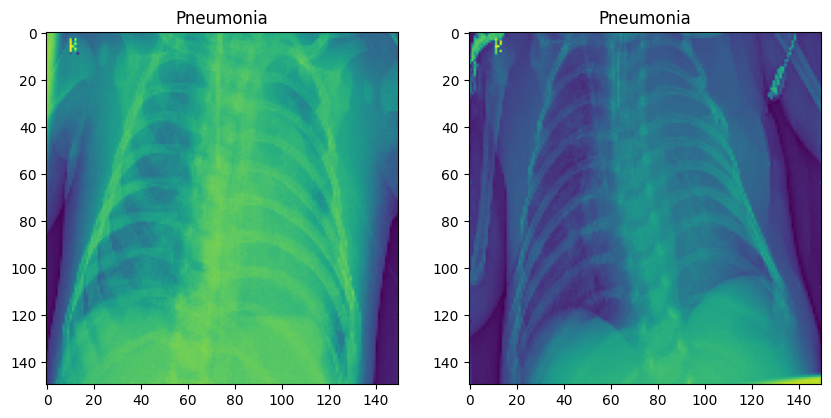

In [ ]:
img_no = np.random.randint(0, X_train.shape[0])
fig, axs = plt.subplots(1,2,figsize=(10,6))
axs[0].imshow(X_train[img_no])
axs[0].set_title(classes[y_train[img_no]])
axs[1].imshow(X_train[img_no + 1])
axs[1].set_title(classes[y_train[img_no + 1]])
axs[0].grid(False)
axs[1].grid(False)
plt.show()

# **Preprocessing Data**

In [ ]:
# Normalisasi data gambar dengan rentang 0:1
X_train = X_train /255
X_val = X_val /255
X_test = X_test /255

In [ ]:
#reshaping gambar
X_train = X_train.reshape(-1, img_size, img_size, 1)
X_val = X_val.reshape(-1, img_size, img_size, 1)
X_test = X_test.reshape(-1, img_size, img_size, 1)

In [ ]:
print('X_train Shape: ' + str(X_train.shape))
print('X_test Shape: ' + str(X_test.shape))
print('X_val Shape: ' + str(X_val.shape))

X_train Shape: (5216, 150, 150, 1)
X_test Shape: (624, 150, 150, 1)
X_val Shape: (16, 150, 150, 1)


In [ ]:
# mengembalikan data menjadi RGB setelah reshaping
X_train, y_train = read_images_from_path('/content/chest_xray/train/', img_size, 0)
X_val, y_val = read_images_from_path('/content/chest_xray/val/', img_size, 0)
X_test, y_test = read_images_from_path('/content/chest_xray/test/', img_size, 0)

In [ ]:
# Normalisasi data gambar menjadi rentang 0:1 setelah reshaping
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

In [ ]:
print('X_train Shape: ' + str(X_train.shape))
print('X_test Shape: ' + str(X_test.shape))
print('X_val Shape: ' + str(X_val.shape))

X_train Shape: (5216, 150, 150, 3)
X_test Shape: (624, 150, 150, 3)
X_val Shape: (16, 150, 150, 3)


# **Augmentasi Data**

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range = 30,
        zoom_range = 0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip = True,
        vertical_flip=False)

In [ ]:
datagen.fit(X_train)

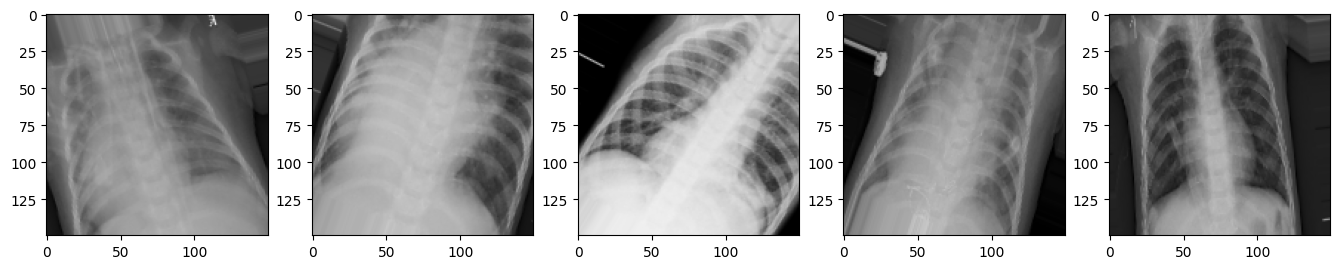

In [ ]:
#Melihat gambar sesudah diaugmentasi
view_datagen = datagen.flow(X_train, batch_size=batch_size)

plt.figure(figsize=(20,15))


for i in range(1, 6):
  plt.subplot(1, 6, i)
  batch = view_datagen.next()
  image = batch[0]
  plt.imshow(image)
plt.show()

# **Menyeimbangkan Kelas**

In [ ]:
TRAIN_IMG_COUNT = len(os.listdir('/content/chest_xray/chest_xray/train/NORMAL/')) + len(os.listdir('/content/chest_xray/chest_xray/train/PNEUMONIA/'))
COUNT_NORMAL = len(os.listdir('/content/chest_xray/chest_xray/train/NORMAL/'))
COUNT_PNEUMONIA = len(os.listdir('/content/chest_xray/chest_xray/train/PNEUMONIA/'))

weight_for_0 = TRAIN_IMG_COUNT / (2 * COUNT_NORMAL)
weight_for_1 = TRAIN_IMG_COUNT / (2 * COUNT_PNEUMONIA)

class_weight = {0: weight_for_0, 1: weight_for_1}

In [ ]:
print('Weight For Normal Class: ' + str(weight_for_0))
print('Weight For Pneumonia Class: ' + str(weight_for_1))

Weight For Normal Class: 1.9441132637853948
Weight For Pneumonia Class: 0.6731166150670794


# **Pre-processing input gambar sesudah augmetasi**

# **Membuat Arsitektur CNN-VGG16 Dengan Aktivasi Swish**

In [ ]:
# Mendefinisikan Aktivasi Swish
def swish(x):
    return x * K.sigmoid(x)

In [ ]:
# Buat model VGG16
base_model = VGG16(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')

# Menampilkan aktivasi bawaan VGG16
for layer in base_model.layers:
    print(f"Layer Name: {layer.name}")
    print(f"Type: {layer.__class__.__name__}")

    # Cek apakah lapisan memiliki fungsi aktivasi
    if hasattr(layer, 'activation'):
        if callable(layer.activation):
            print(f"Activation: {layer.activation.__name__}")
        else:
            print(f"Activation: {layer.activation}")
    else:
        print("Activation: None")

    print()

58889256/58889256 [==============================] - 3s 0us/step
Layer Name: input_1
Type: InputLayer
Activation: None

Layer Name: block1_conv1
Type: Conv2D
Activation: relu

Layer Name: block1_conv2
Type: Conv2D
Activation: relu

Layer Name: block1_pool
Type: MaxPooling2D
Activation: None

Layer Name: block2_conv1
Type: Conv2D
Activation: relu

Layer Name: block2_conv2
Type: Conv2D
Activation: relu

Layer Name: block2_pool
Type: MaxPooling2D
Activation: None

Layer Name: block3_conv1
Type: Conv2D
Activation: relu

Layer Name: block3_conv2
Type: Conv2D
Activation: relu

Layer Name: block3_conv3
Type: Conv2D
Activation: relu

Layer Name: block3_pool
Type: MaxPooling2D
Activation: None

Layer Name: block4_conv1
Type: Conv2D
Activation: relu

Layer Name: block4_conv2
Type: Conv2D
Activation: relu

Layer Name: block4_conv3
Type: Conv2D
Activation: relu

Layer Name: block4_pool
Type: MaxPooling2D
Activation: None

Layer Name: block5_conv1
Type: Conv2D
Activation: relu

Layer Name: block5_c

In [ ]:
# Mengganti Aktivasi bawaan Dengan aktivasi Swish
for layer in base_model.layers:
  if (hasattr(layer, 'activation')) == True:
    layer.activation = swish


# Menampilkan aktivasi VGG16 setelah diganti
for layer in base_model.layers:
    print(f"Layer Name: {layer.name}")
    print(f"Type: {layer.__class__.__name__}")

    # Cek apakah lapisan memiliki fungsi aktivasi
    if hasattr(layer, 'activation'):
        if callable(layer.activation):
            print(f"Activation: {layer.activation.__name__}")
        else:
            print(f"Activation: {layer.activation}")
    else:
        print("Activation: None")

    print()

Layer Name: input_1
Type: InputLayer
Activation: None

Layer Name: block1_conv1
Type: Conv2D
Activation: swish

Layer Name: block1_conv2
Type: Conv2D
Activation: swish

Layer Name: block1_pool
Type: MaxPooling2D
Activation: None

Layer Name: block2_conv1
Type: Conv2D
Activation: swish

Layer Name: block2_conv2
Type: Conv2D
Activation: swish

Layer Name: block2_pool
Type: MaxPooling2D
Activation: None

Layer Name: block3_conv1
Type: Conv2D
Activation: swish

Layer Name: block3_conv2
Type: Conv2D
Activation: swish

Layer Name: block3_conv3
Type: Conv2D
Activation: swish

Layer Name: block3_pool
Type: MaxPooling2D
Activation: None

Layer Name: block4_conv1
Type: Conv2D
Activation: swish

Layer Name: block4_conv2
Type: Conv2D
Activation: swish

Layer Name: block4_conv3
Type: Conv2D
Activation: swish

Layer Name: block4_pool
Type: MaxPooling2D
Activation: None

Layer Name: block5_conv1
Type: Conv2D
Activation: swish

Layer Name: block5_conv2
Type: Conv2D
Activation: swish

Layer Name: block

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
#setting a classifier on top of the vgg16 model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(units = 256 , activation = swish))
model.add(Dropout(0.5))
model.add(Dense(units = 1, activation = 'sigmoid'))

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer = optimizer , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 2097665 (8.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
history = model.fit(
    datagen.flow(X_train,y_train, batch_size = batch_size),
    epochs = epoch,
    validation_data = datagen.flow(X_val, y_val)
    )


Epoch 1/10
82/82 [==============================] - 52s 470ms/step - loss: 0.4798 - accuracy: 0.7730 - val_loss: 0.7182 - val_accuracy: 0.5625
Epoch 2/10
82/82 [==============================] - 33s 403ms/step - loss: 0.3018 - accuracy: 0.8708 - val_loss: 0.6375 - val_accuracy: 0.6250
Epoch 3/10
82/82 [==============================] - 34s 410ms/step - loss: 0.2459 - accuracy: 0.9020 - val_loss: 0.7192 - val_accuracy: 0.6875
Epoch 4/10
82/82 [==============================] - 33s 402ms/step - loss: 0.2236 - accuracy: 0.9061 - val_loss: 0.6581 - val_accuracy: 0.6875
Epoch 5/10
82/82 [==============================] - 34s 406ms/step - loss: 0.2045 - accuracy: 0.9176 - val_loss: 0.8460 - val_accuracy: 0.6875
Epoch 6/10
82/82 [==============================] - 34s 413ms/step - loss: 0.1935 - accuracy: 0.9262 - val_loss: 0.6855 - val_accuracy: 0.6875
Epoch 7/10
82/82 [==============================] - 34s 411ms/step - loss: 0.1893 - accuracy: 0.9256 - val_loss: 0.4978 - val_accuracy: 0.7500

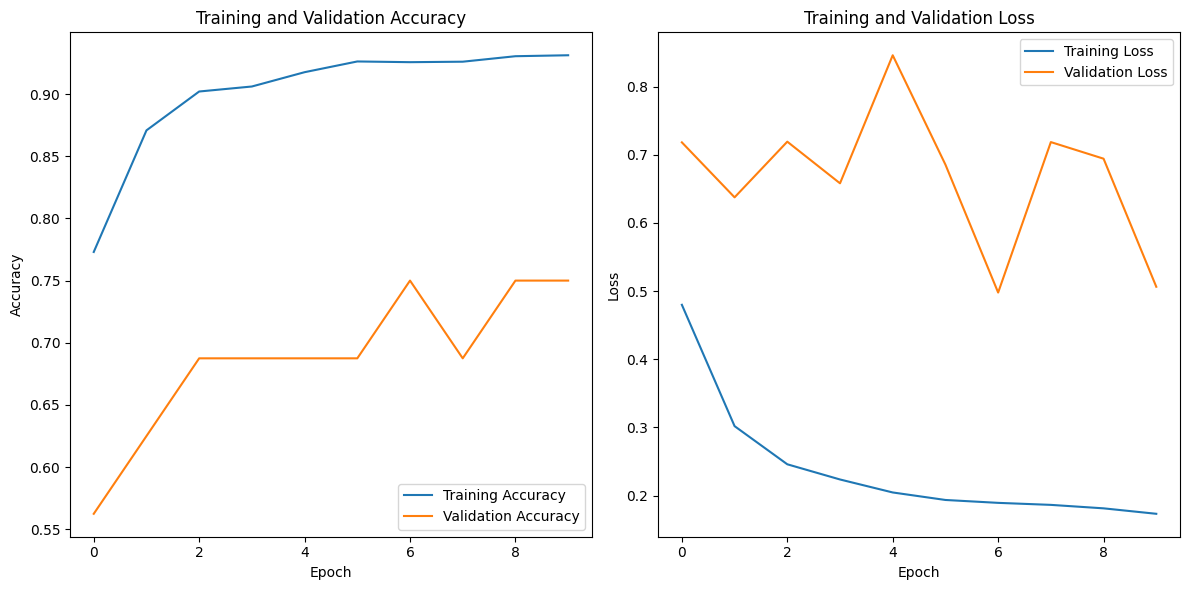

In [ ]:
# Visualisasi Grafik Pelatihan
plt.figure(figsize=(12, 6))

# Grafik Akurasi Pelatihan dan Validasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Grafik Loss Pelatihan dan Validasi
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Prediksi pada data uji
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(np.int32)

accuracy = accuracy_score(y_test, y_pred_classes)
print(f'Accuracy: {accuracy:.2%}')
loss_test = model.evaluate(X_test, y_test, verbose=0)
print(f'Loss on test data: {loss_test[0]:.4f}')

20/20 [==============================] - 2s 89ms/step
Accuracy: 91.51%
Loss on test data: 0.2391


In [ ]:
# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=classes))

Classification Report:
              precision    recall  f1-score   support

      Normal       0.93      0.84      0.88       234
   Pneumonia       0.91      0.96      0.93       390

    accuracy                           0.92       624
   macro avg       0.92      0.90      0.91       624
weighted avg       0.92      0.92      0.91       624



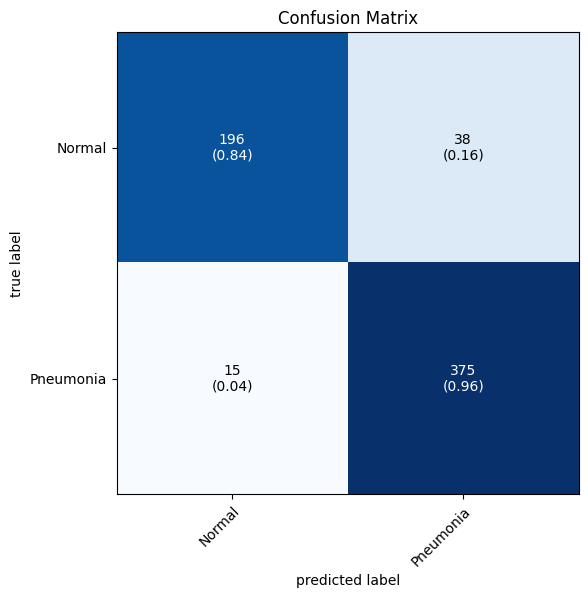

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plot_confusion_matrix(conf_mat=cm, figsize=(6, 6), class_names=classes, show_normed=True)
plt.title('Confusion Matrix')
plt.show()

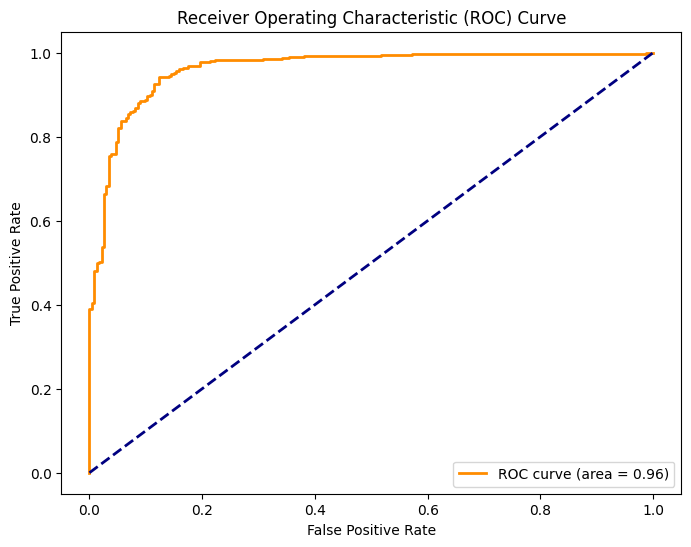

In [ ]:
# ROC-AUC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc_value = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_value))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()